# Pet's Faces Dataset

Используем упрощенный датасет [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) с вырезанными лицами домашних животных. Для начала загружаем датасет:

In [1]:
# !wget https://mslearntensorflowlp.blob.core.windows.net/data/petfaces.tar.gz
# !tar xfz petfaces.tar.gz
# !rm petfaces.tar.gz

--2022-05-18 18:57:08--  https://mslearntensorflowlp.blob.core.windows.net/data/petfaces.tar.gz
Resolving mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)... 20.150.90.68
Connecting to mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)|20.150.90.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24483412 (23M) [application/x-gzip]
Saving to: 'petfaces.tar.gz'

     0K .......... .......... .......... .......... ..........  0%  199K 2m0s
    50K .......... .......... .......... .......... ..........  0% 3.13M 64s
   100K .......... .......... .......... .......... ..........  0%  422K 61s
   150K .......... .......... .......... .......... ..........  0% 3.58M 47s
   200K .......... .......... .......... .......... ..........  1% 28.5M 38s
   250K .......... .......... .......... .......... ..........  1%  428K 41s
   300K .......... .......... .......... .......... ..........  1% 2.92M 36s

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary
from time import time

In [2]:
def display_images(data, max_n = 8):
    n = min(max_n, len(data[0]))
    fig, ax = plt.subplots(1, n)
    for i in range(n):
        img = data[0][i].numpy()
        ax[i].imshow(img.transpose((1, 2, 0)))
        ax[i].axis("off")
    fig.set_size_inches(fig.get_size_inches() * n)
    plt.tight_layout()
    plt.show()

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder('./petfaces', transform=transform)
train_data, test_data = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)])

In [4]:
batch_size = 60
train = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test = torch.utils.data.DataLoader(test_data, batch_size=1)

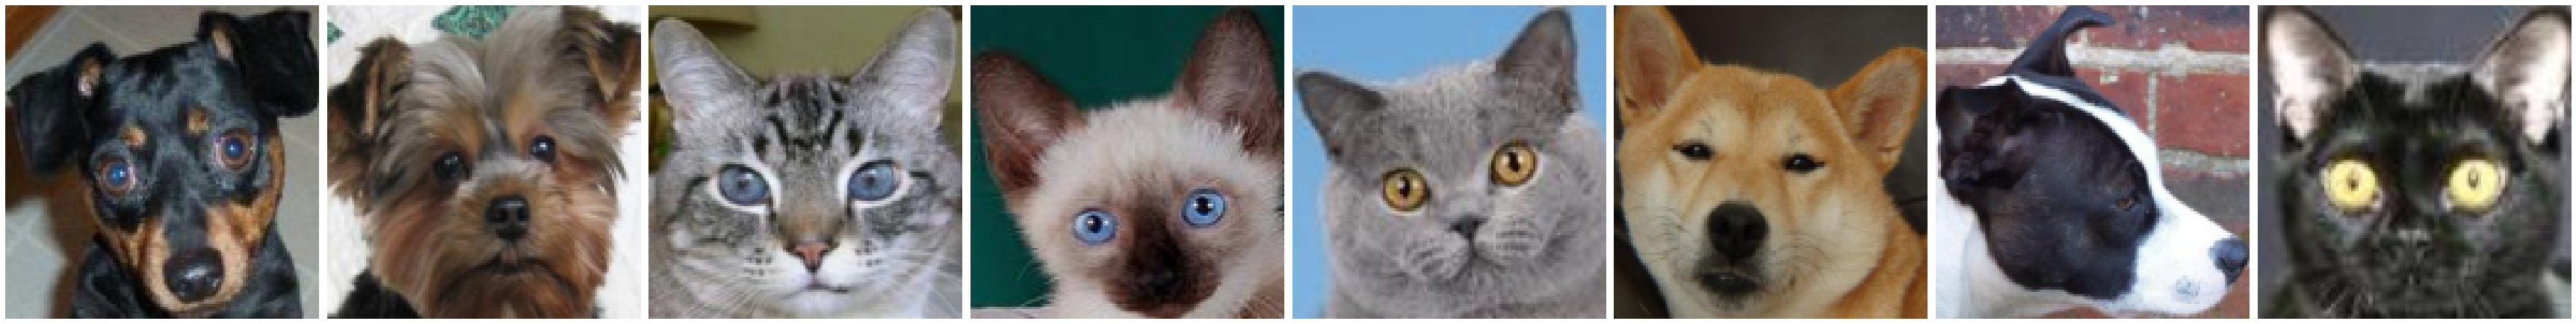

In [5]:
display_images(next(iter(train)))

In [19]:
CLASSES = 35
CATS = 11

def scores(net, test):
    matrix = np.zeros((CLASSES, CLASSES))
    correct = 0
    bin_correct = 0
    total = len(test)
    with torch.no_grad():
        for (x, y) in test:
            z = net(x)
            p = torch.argmax(torch.softmax(z, 1))
            matrix[y[0]][p] += 1
            if p == y[0]:
                correct += 1
            if (p <= CATS) == (y[0] <= CATS):
                bin_correct += 1
    acc = correct / len(test)
    bin_acc = bin_correct / len(test)
    return acc, bin_acc, matrix

def top_k_accuracy(net, test, k):
    correct = 0
    total = len(test)
    with torch.no_grad():
        for (x, y) in test:
            z = 1 - torch.softmax(net(x), 1).numpy()[0]
            p = np.argpartition(z, k-1)[:k]
            if y[0].item() in p:
                correct += 1
    acc = correct / len(test)
    return acc

def fit(net, train, test, epochs=10, lr=0.0001):
    optim = torch.optim.Adam(net.parameters(), lr=lr)
    accuracy = [[], []]
    start = time()
    for ep in range(epochs):
        correct = 0
        for (x, y) in train:
            z = net(x)
            loss = torch.nn.functional.cross_entropy(z,y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            correct += (torch.argmax(torch.softmax(z, 1), axis=1) == y).sum().item()
            
        acc = correct / len(train.dataset)
        val_acc, val_bin_acc, matrix = scores(net, test)
        accuracy[0].append(acc)
        accuracy[1].append(val_acc)
        print(f"Epoch {ep+1}, acc = {acc:.4f}, val acc = {val_acc:.4f}, val bin acc = {val_bin_acc:.4f}")
    end = time()
        
    print("Top-3 accuracy: ", top_k_accuracy(net, test, 3))
    figure = plt.figure(figsize=(16, 5))
    axes = figure.add_subplot(1, 2, 1)
    plt.xticks([])
    plt.yticks([])
    matr = plt.imshow(matrix)
    figure.colorbar(matr)
    axes = figure.add_subplot(1, 2, 2)
    plt.xticks(range(1, epochs+1))
    plt.plot(accuracy[0], 'k--')
    plt.plot(accuracy[1], 'g-')
    plt.show()
    print("Elapsed time: {:.2f} m".format((end - start) / 60))

In [7]:
class MyNet(torch.nn.Module):
    def __init__(self, conv=[3, 64, 128, 128], kernel=[7, 5, 3], stride=[2, 1, 1], lin=[128, 64, 35], image_size=128, activ=nn.ReLU()):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = conv[0], out_channels = conv[1], kernel_size = kernel[0], stride = stride[0])
        self.conv2 = nn.Conv2d(in_channels = conv[1], out_channels = conv[2], kernel_size = kernel[1], stride = stride[1])
        self.conv3 = nn.Conv2d(in_channels = conv[2], out_channels = conv[3], kernel_size = kernel[2], stride = stride[2])
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.activ = activ
        
        self.lin_input = image_size
        for i in range(3):
            self.lin_input = (self.lin_input - kernel[i] // 2 * 2) // stride[i] // 2
        self.lin_input *= self.lin_input * conv[-1]
        
        self.lin1 = nn.Linear(self.lin_input, lin[0])
        self.lin2 = nn.Linear(lin[0], lin[1])
        self.lin3 = nn.Linear(lin[1], lin[2])

    def forward(self, x):
        x = self.pool(self.activ(self.conv1(x)))
        x = self.pool(self.activ(self.conv2(x)))
        x = self.pool(self.activ(self.conv3(x)))
        x = x.view(-1, self.lin_input)
        x = self.activ(self.lin1(x))
        x = self.activ(self.lin2(x))
        x = self.lin3(x)
        return x

In [340]:
net = MyNet(conv=[3, 64, 96, 128], kernel=[11, 5, 3], stride=[2, 1, 1], lin=[256, 128, 35], activ=nn.Tanh())
summary(net, (3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
MyNet                                    --                        --
├─Conv2d: 1-1                            [64, 59, 59]              23,296
├─Tanh: 1-2                              [64, 59, 59]              --
├─MaxPool2d: 1-3                         [64, 29, 29]              --
├─Conv2d: 1-4                            [96, 25, 25]              153,696
├─Tanh: 1-5                              [96, 25, 25]              --
├─MaxPool2d: 1-6                         [96, 12, 12]              --
├─Conv2d: 1-7                            [128, 10, 10]             110,720
├─Tanh: 1-8                              [128, 10, 10]             --
├─MaxPool2d: 1-9                         [128, 5, 5]               --
├─Linear: 1-10                           [1, 256]                  819,456
├─Tanh: 1-11                             [1, 256]                  --
├─Linear: 1-12                           [1, 128]                 

Epoch 1, acc = 0.1156, val acc = 0.1695, val bin acc = 0.7045
Epoch 2, acc = 0.2371, val acc = 0.2613, val bin acc = 0.7481
Epoch 3, acc = 0.3394, val acc = 0.3126, val bin acc = 0.7900
Epoch 4, acc = 0.4017, val acc = 0.3561, val bin acc = 0.8212
Epoch 5, acc = 0.4519, val acc = 0.3935, val bin acc = 0.8398
Epoch 6, acc = 0.5010, val acc = 0.4059, val bin acc = 0.8367
Epoch 7, acc = 0.5539, val acc = 0.4184, val bin acc = 0.8569
Epoch 8, acc = 0.5956, val acc = 0.4479, val bin acc = 0.8616
Epoch 9, acc = 0.6283, val acc = 0.4619, val bin acc = 0.8865
Epoch 10, acc = 0.6598, val acc = 0.4806, val bin acc = 0.8818
Top-3 accuracy:  0.6982892690513219


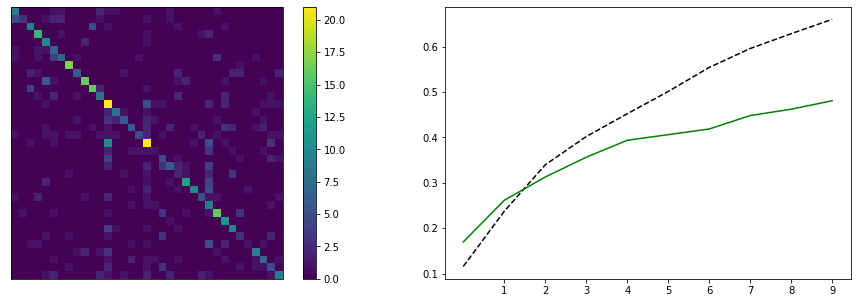

Elapsed time: 8.04 m


In [349]:
fit(net, train, test, epochs=10, lr=2e-4)

Epoch 1, acc = 0.0428, val acc = 0.0669, val bin acc = 0.6656
Epoch 2, acc = 0.0728, val acc = 0.1011, val bin acc = 0.6703
Epoch 3, acc = 0.1491, val acc = 0.1695, val bin acc = 0.6439
Epoch 4, acc = 0.2254, val acc = 0.2037, val bin acc = 0.7107
Epoch 5, acc = 0.2954, val acc = 0.2442, val bin acc = 0.7278
Epoch 6, acc = 0.3464, val acc = 0.2955, val bin acc = 0.7636
Epoch 7, acc = 0.3967, val acc = 0.3064, val bin acc = 0.7760
Epoch 8, acc = 0.4391, val acc = 0.3188, val bin acc = 0.8056
Epoch 9, acc = 0.4780, val acc = 0.3390, val bin acc = 0.8398
Epoch 10, acc = 0.5033, val acc = 0.3826, val bin acc = 0.8569
Top-3 accuracy:  0.6314152410575428


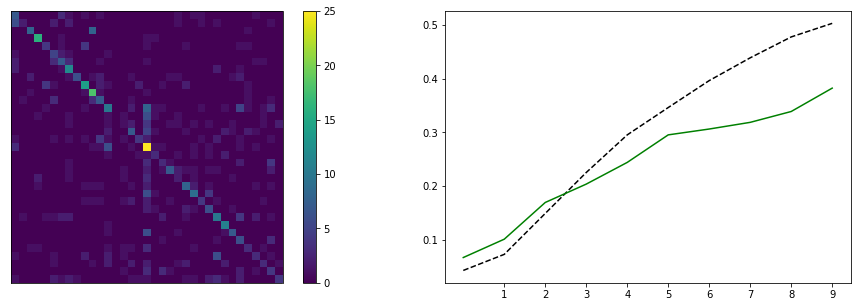

Elapsed time: 7.75 m


In [350]:
net = MyNet(conv=[3, 64, 96, 128], kernel=[11, 5, 3], stride=[2, 1, 1], lin=[256, 128, 35], activ=nn.ReLU())
fit(net, train, test, epochs=10, lr=2e-4)

Epoch 1, acc = 0.0950, val acc = 0.1804, val bin acc = 0.7030
Epoch 2, acc = 0.2624, val acc = 0.3344, val bin acc = 0.7932
Epoch 3, acc = 0.3834, val acc = 0.4044, val bin acc = 0.8087
Epoch 4, acc = 0.4912, val acc = 0.4168, val bin acc = 0.8585
Epoch 5, acc = 0.5644, val acc = 0.4308, val bin acc = 0.8631
Epoch 6, acc = 0.6197, val acc = 0.4681, val bin acc = 0.8865
Epoch 7, acc = 0.6575, val acc = 0.4961, val bin acc = 0.8880
Epoch 8, acc = 0.7520, val acc = 0.5101, val bin acc = 0.8974
Epoch 9, acc = 0.8062, val acc = 0.5194, val bin acc = 0.9098
Epoch 10, acc = 0.8579, val acc = 0.5008, val bin acc = 0.9005
Top-3 accuracy:  0.7247278382581649


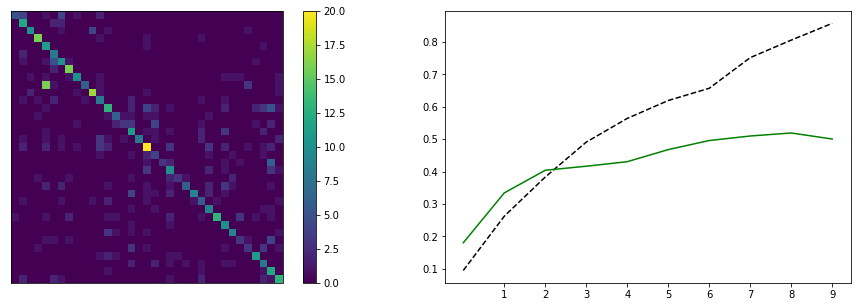

Elapsed time: 8.40 m


In [351]:
net = MyNet(conv=[3, 64, 96, 128], kernel=[11, 5, 3], stride=[2, 1, 1], lin=[1024, 1024, 35], activ=nn.Tanh())
fit(net, train, test, epochs=10, lr=2e-4)

In [8]:
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return (self.transform(item[0]), item[1])

In [9]:
augmentation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    transforms.ToTensor()
])

train_aug_data = TransformDataset(train_data, augmentation)
train_aug = torch.utils.data.DataLoader(train_aug_data, batch_size=100)

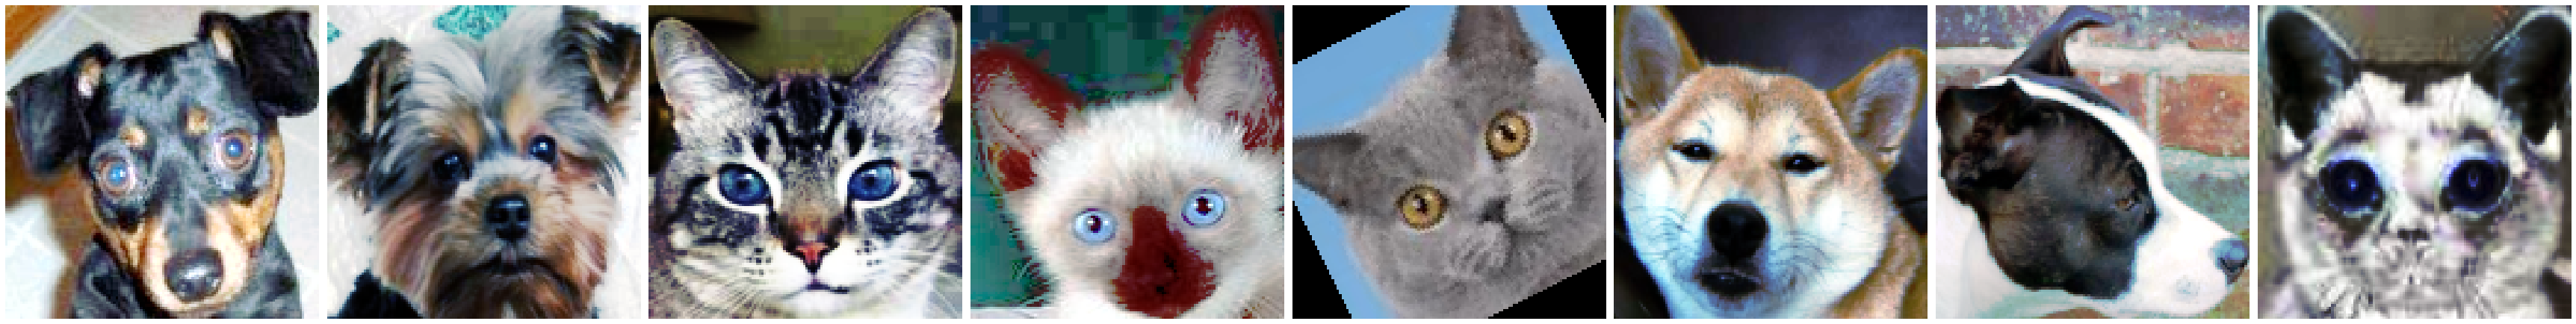

In [10]:
display_images(next(iter(train_aug)))

Epoch 1, acc = 0.0537, val acc = 0.1042, val bin acc = 0.6734
Epoch 2, acc = 0.1105, val acc = 0.2224, val bin acc = 0.7356
Epoch 3, acc = 0.1876, val acc = 0.3110, val bin acc = 0.7885
Epoch 4, acc = 0.2386, val acc = 0.3624, val bin acc = 0.8212
Epoch 5, acc = 0.2775, val acc = 0.4339, val bin acc = 0.8585
Epoch 6, acc = 0.3219, val acc = 0.4510, val bin acc = 0.8958
Epoch 7, acc = 0.3371, val acc = 0.4821, val bin acc = 0.9098
Epoch 8, acc = 0.3768, val acc = 0.5350, val bin acc = 0.9082
Epoch 9, acc = 0.4037, val acc = 0.5630, val bin acc = 0.9269
Epoch 10, acc = 0.4418, val acc = 0.5816, val bin acc = 0.9409
Top-3 accuracy:  0.8195956454121306


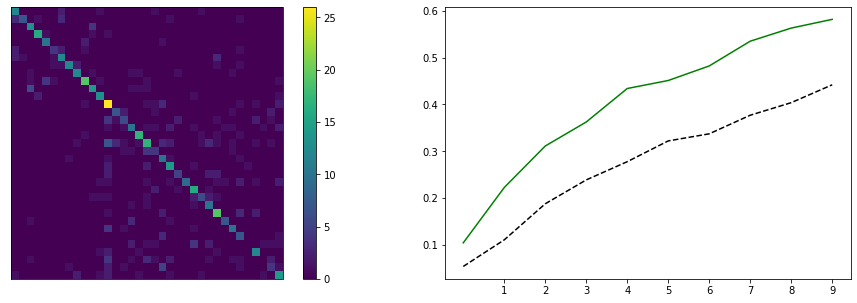

Elapsed time: 10.46 m


In [352]:
net = MyNet(conv=[3, 64, 96, 128], kernel=[11, 7, 5], stride=[2, 1, 1], lin=[1024, 1024, 35], activ=nn.Tanh())
fit(net, train_aug, test, epochs=10, lr=2e-4)

Epoch 1, acc = 0.0646, val acc = 0.1120, val bin acc = 0.6579
Epoch 2, acc = 0.1312, val acc = 0.2317, val bin acc = 0.7216
Epoch 3, acc = 0.1938, val acc = 0.2737, val bin acc = 0.7745
Epoch 4, acc = 0.2561, val acc = 0.3328, val bin acc = 0.8087
Epoch 5, acc = 0.2877, val acc = 0.3375, val bin acc = 0.8087
Epoch 6, acc = 0.3227, val acc = 0.3935, val bin acc = 0.8631
Epoch 7, acc = 0.3589, val acc = 0.4044, val bin acc = 0.8383
Epoch 8, acc = 0.3799, val acc = 0.4339, val bin acc = 0.8756
Epoch 9, acc = 0.4367, val acc = 0.4526, val bin acc = 0.8818
Epoch 10, acc = 0.4445, val acc = 0.4806, val bin acc = 0.9051
Epoch 11, acc = 0.4659, val acc = 0.4697, val bin acc = 0.8896
Epoch 12, acc = 0.4944, val acc = 0.4852, val bin acc = 0.8880
Epoch 13, acc = 0.5138, val acc = 0.5179, val bin acc = 0.9082
Epoch 14, acc = 0.5465, val acc = 0.5272, val bin acc = 0.9160
Epoch 15, acc = 0.5527, val acc = 0.4930, val bin acc = 0.8942
Epoch 16, acc = 0.5671, val acc = 0.5334, val bin acc = 0.9160
E

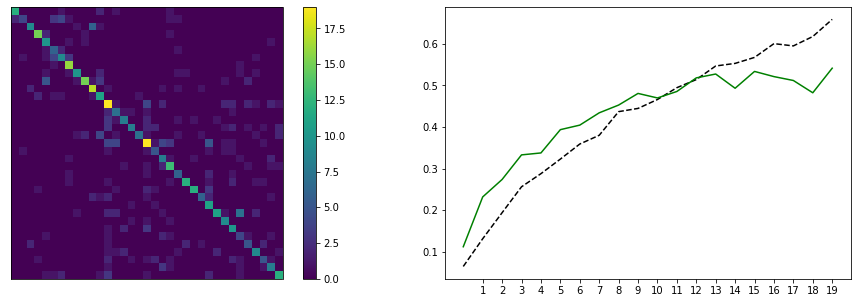

Elapsed time: 20.88 m


In [369]:
net = MyNet(conv=[3, 64, 96, 128], kernel=[11, 7, 5], stride=[2, 1, 1], lin=[1024, 1024, 35], activ=nn.Tanh())
fit(net, train_aug, test, epochs=20, lr=2e-4)

Epoch 1, acc = 0.0903, val acc = 0.1804, val bin acc = 0.7123
Epoch 2, acc = 0.1997, val acc = 0.2691, val bin acc = 0.7667
Epoch 3, acc = 0.2880, val acc = 0.3841, val bin acc = 0.8460
Epoch 4, acc = 0.3484, val acc = 0.4152, val bin acc = 0.8538
Epoch 5, acc = 0.3931, val acc = 0.4603, val bin acc = 0.8756
Epoch 6, acc = 0.4231, val acc = 0.4697, val bin acc = 0.8725
Epoch 7, acc = 0.4811, val acc = 0.4946, val bin acc = 0.8958
Epoch 8, acc = 0.5103, val acc = 0.5070, val bin acc = 0.8787
Epoch 9, acc = 0.5418, val acc = 0.5148, val bin acc = 0.9082
Epoch 10, acc = 0.6030, val acc = 0.5599, val bin acc = 0.9238
Top-3 accuracy:  0.7853810264385692


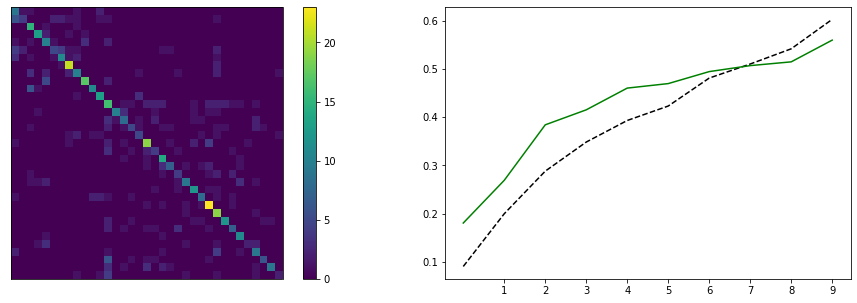

Elapsed time: 21.14 m


In [18]:
net = MyNet(conv=[3, 64, 96, 128], kernel=[3, 3, 3], stride=[1, 1, 1], lin=[256, 256, 35], activ=nn.Tanh())
fit(net, train_aug, test, epochs=10, lr=4e-4)